In [1]:
#Without Shuffling
import os
import cv2
import numpy as np
from keras.applications.densenet import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define paths
dataset_path = "My Usage/MS Coursework/Sem2/Capstone/bloodcells_dataset"

# Define image size
img_size = (224, 224)

# Load and preprocess data
X = []
y = []
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            try:
                image = cv2.imread(image_path)
                image = cv2.resize(image, img_size)
                X.append(image)
                y.append(class_name)
            except Exception as e:
                print(f"Error loading image: {image_path}, {e}")

X = np.array(X)
y = np.array(y)

# Convert class labels to numeric format
label_to_index = {label: index for index, label in enumerate(np.unique(y))}
y = np.array([label_to_index[label] for label in y])

# Convert labels to categorical format
num_classes = len(label_to_index)
y = to_categorical(y, num_classes=num_classes)

# Split data into train and test sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Load the DenseNet201 base model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define the Adam optimizer with default parameters
adam_optimizer = Adam()

# Compile the model with the Adam optimizer
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Train the model
epochs = 20
batch_size = 32
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

# Compute precision, recall, and F1 score
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy: {test_acc:.8f}')
print(f'Test Precision: {precision:.8f}')
print(f'Test Recall: {recall:.8f}')
print(f'Test F1 Score: {f1:.8f}')

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)
for label, index in label_to_index.items():
    correct_predictions = np.sum(np.logical_and(y_true == index, y_pred == index))
    incorrect_predictions = np.sum(np.logical_and(y_true == index, y_pred != index))
    print(f'Label: {label}')
    print(f'Total Correct Predictions: {correct_predictions}')
    print(f'Total Incorrect Predictions: {incorrect_predictions}')


Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1759s 5s/step - accuracy: 0.6679 - loss: 0.9842 - val_accuracy: 0.5478 - val_loss: 1.3682 - learning_rate: 0.0010
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1153s 4s/step - accuracy: 0.8358 - loss: 0.4901 - val_accuracy: 0.6916 - val_loss: 1.0140 - learning_rate: 0.0010
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1139s 4s/step - accuracy: 0.8607 - loss: 0.4131 - val_accuracy: 0.5951 - val_loss: 1.5790 - learning_rate: 0.0010
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1144s 4s/step - accuracy: 0.8694 - loss: 0.3690 - val_accuracy: 0.8232 - val_loss: 0.5369 - learning_rate: 0.0010
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1060s 4s/step - accuracy: 0.8748 - loss: 0.3599 - val_accuracy: 0.8379 - val_loss: 0.4426 - learning_rate: 0.0010
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1065s 4s/step - accuracy: 0.8909 - loss: 0.3189 - val_accuracy: 0.8433 - val_loss: 0.4717 - learning_rate: 0.0010
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8947 - loss

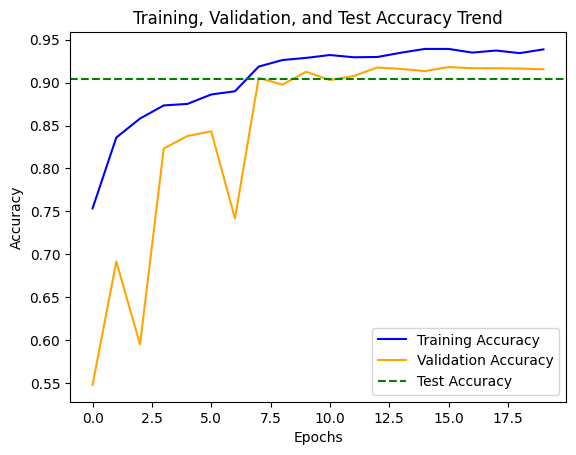

In [2]:
#accuracy trendline
import matplotlib.pyplot as plt

# Extracting training, validation, and test accuracy from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Adding test accuracy line
plt.axhline(y=test_acc, color='green', linestyle='--', label='Test Accuracy')

# Adding legend, title, and labels
plt.legend()
plt.title('Training, Validation, and Test Accuracy Trend (Without Shuffling)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Show plot
plt.show()

In [7]:
#With shuffling 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications.densenet import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from sklearn.utils import shuffle

# Define paths
dataset_path = "My Usage/MS Coursework/Sem2/Capstone/bloodcells_dataset"

# Define image size
img_size = (224, 224)

# Load and preprocess data
X = []
y = []
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path)
            image = cv2.resize(image, img_size)
            X.append(image)
            y.append(class_name)

X = np.array(X)
y = np.array(y)

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Convert class labels to numeric format
label_to_index = {label: index for index, label in enumerate(np.unique(y))}
y = np.array([label_to_index[label] for label in y])

# Reshape labels to have two dimensions
y = y.reshape(-1, 1)

# Split data into train and test sets using stratified sampling
X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Load the DenseNet201 base model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(label_to_index), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define the Adam optimizer with desired parameters
adam_optimizer = Adam(learning_rate=0.001)

# Compile the model with the Adam optimizer
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 20
batch_size = 64
history = model.fit(X_train_shuffled, y_train_shuffled, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_shuffled, y_test_shuffled)

print(f'Test Accuracy: {test_acc:.2f}')


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2734s 18s/step - accuracy: 0.4054 - loss: 3.2119 - val_accuracy: 0.6498 - val_loss: 0.9585
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2691s 18s/step - accuracy: 0.7275 - loss: 0.7772 - val_accuracy: 0.7330 - val_loss: 0.7607
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2681s 18s/step - accuracy: 0.7714 - loss: 0.6461 - val_accuracy: 0.7321 - val_loss: 0.7439
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2645s 18s/step - accuracy: 0.7903 - loss: 0.5877 - val_accuracy: 0.8224 - val_loss: 0.5060
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1263s 8s/step - accuracy: 0.8141 - loss: 0.5228 - val_accuracy: 0.7998 - val_loss: 0.5680
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1249s 8s/step - accuracy: 0.8310 - loss: 0.4854 - val_accuracy: 0.8203 - val_loss: 0.5351
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1263s 8s/step - accuracy: 0.8487 - loss: 0.4355 - val_accuracy: 0.7931 - val_loss: 0.6056
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1252s 8s/step - accuracy: 0.8348 - loss: 0.464

In [8]:
print(f'Test Precision: {precision:.8f}')
print(f'Test Recall: {recall:.8f}')
print(f'Test F1 Score: {f1:.8f}')

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)
for label, index in label_to_index.items():
    correct_predictions = np.sum(np.logical_and(y_true == index, y_pred == index))
    incorrect_predictions = np.sum(np.logical_and(y_true == index, y_pred != index))
    print(f'Label: {label}')
    print(f'Total Correct Predictions: {correct_predictions}')
    print(f'Total Incorrect Predictions: {incorrect_predictions}')



161/161 ━━━━━━━━━━━━━━━━━━━━ 1215s 7s/step
Test Accuracy: 0.88670045
Test Precision: 1.00000000
Test Recall: 0.06708268
Test F1 Score: 0.12573099
Confusion Matrix:
[[ 344  814  449  872  393  465 1067  724]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]]
Label: basophil
Total Correct Predictions: 344
Total Incorrect Predictions: 4784
Label: eosinophil
Total Correct Predictions: 0
Total Incorrect Predictions: 0
Label: erythroblast
Total Correct Predictions: 0
Total Incorrect Predictions: 0
Label: ig
Total Correct Predictions: 0
Total Incorrect Predictions: 0
Label: lymphocyte
Total Correct Predictions: 0
Total Incorrect Predictions: 0
Label: monocyte
Total Correct Predictions: 0
Total Incorrect Predictions: 0
Label: neutrophil
Total Corr

C:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
